# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №5 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 15 декабря 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 декабря, -4 балла после 06:00 24 декабря, -6 баллов после 06:00 31 декабря -8 баллов  после 06:00 7 января


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (6 баллов)

###### Боевое применение (2 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

# Определяем, что вам досталось

Укажите свою фамилию на русском языке в поле ниже.

In [1]:
import hashlib

def lucky_hash(text):
    return int(hashlib.md5(text.encode('utf-8')).hexdigest()[:8], 16) 

USER_NAME = u"Притугин".lower()

ALGORITHMS = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - число кластеров)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)",]

print ("Имплементируйте алгоритм кластеризации %s"\
% (
    ALGORITHMS[lucky_hash(USER_NAME[::-1]) % 2]
) )

Имплементируйте алгоритм кластеризации Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)


Не стоит переживать из-за Вашего варианта. Технически оба алгоритма несложно реализовать.  EM алгоритма бояться не стоит, Вам будет нужно просто реализовать уже выведенные формулы для E и M шагов.

In [2]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

#%load_ext pycodestyle_magic

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать один из двух популярных методов кластеризации: разделение смеси нормальных распределений или агломеративную кластеризацию. 

## Смесь нормальных распределений



Предполагаем, что наши данные порождены смесью $k$ нормальных распределений, то есть 

$$ p(\mathbf{x}) = \sum_k \pi_k \mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{\Sigma}_k) $$,


где $\mathcal{N}$ - многомерное нормальное распределение размерности ${D}$:

$$\mathcal{N(\mathbf{x} | \mathbf{\mu}, \mathbf{\Sigma}}) = \frac{1}{(2 \pi)^{D/2}} \frac{1}{|\mathbf{\Sigma}|^{1/2}} \exp \left\{-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma^{-1}} (\mathbf{x} - \mathbf{\mu})\right\}$$

**Параметры**  


${D}$-мерный вектор средних

$$\mathbf{\mu}$$

$D \times D$-мерная матрица ковариации   (симметричная)


$$\mathbf{\Sigma} = E[(\mathbf{x} - \mathbf{\mu})(\mathbf{x} - \mathbf{\mu})^T]$$



Необходимо оценить параметры $\pi_k, \mathbf{\mu_k}, \mathbf{\Sigma_k} $ для всех компонент смеси.  Сделать это можно с помощью EM алгоритма - алгоритма, который находит оценку максимального правдоподобия в задаче со скрытыми переменными. 

## Expectation Maximization

**I** До цикла проинциализировать случайно  $\mu_k, \Sigma_k, \pi_k$ ($\pi_k$ должны суммироваться в 1)

**E** Expectation: при фиксированных $\mu_k, \Sigma_k, \pi_k$
$$
p(z_k = 1| x_n ) = \gamma(z_{nk}) = \frac{\pi_k \mathcal{N} (\mathbf{x}_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N} (\mathbf{x}_n | \mu_j, \Sigma_j)}
$$
**M** Maximization: при фиксированных $\gamma(z_{nk})$
$$
N_k = \sum_{n=1}^N \gamma(z_{nk}), \;\; \mu_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n
$$
$$
\Sigma_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n - \mu_k)(\mathbf{x}_n - \mu_k)^T
$$
$$
\pi_k = \frac{N_k}{N}
$$
**S** Остановиться при достижении сходимости

Номер кластера для $n$ объекта будем брать по принципу maximum a-posteriori, то есть относить объект к тому кластеру, у которого максимальна апостериорная вероятность:
$$ k_n =  \arg\underset{k}\max  p(z_k = 1| x_n ) =  \arg\underset{k}\max \gamma(z_{nk}) $$

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Для простоты будем использовать евклидово расстояние между объектами.



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

# $ L(C) = \sum_{k=1}^{K} \sum_{i \in C_k} \left\lVert x_i - \mu_k \right\rVert^2 $

Основная идея заключается в том, что на каждой итерации перевычисляется центр масс для каждого кластера, полученного на предыдущем шаге, затем векторы разбиваются на кластеры вновь в соответствии с тем, какой из новых центров оказался ближе по выбранной метрике.

Алгоритм завершается, когда на какой-то итерации не происходит изменения внутрикластерного расстояния. Это происходит за конечное число итераций, так как количество возможных разбиений конечного множества конечно, а на каждом шаге суммарное квадратичное отклонение V уменьшается, поэтому зацикливание невозможно.

# ----------------------------

Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



***Ваше решение здесь***

EM-алгоритм решает задачу максимизации полного правоподобия путем попеременной
оптимизации по параметрам и по скрытым переменным

Представим неполное правдоподобие в виде суммы двух функций (из вашей лекции):

# $ log(p(X | Θ)) = L(q, Θ) + KL (q || p) $

Проведем E и M шаг (не хочу выписывать формулы из pdf)

На каждой его итерации значение правдоподобия не уменьшается (факт из вашей лекции)

Если правдоподобие ограничено сверху, то последовательность значений правдоподобия
 $ \{p(X | Θ^i)\}_i $ обязательно сойдется...
 
# --------------------------------

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчета расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

Очевидно, что:

$ d_{\min}(U \cup V, S) = min(d_{\min}(U, S), d_{\min}(V, S)) $

$ d_{\max}(U \cup V, S) = max(d_{\max}(U, S), d_{\max}(V, S)) $

Теперь вспомним стандартные задачки на собеседованиях.

Как найти минимум(максимум) чисел x, y без операторов сравнения?

$ min(x,\,y) = \frac{1}{2} x + \frac{1}{2} y - \frac{1}{2} | x - y | $

$ max(x,\,y) = \frac{1}{2} x + \frac{1}{2} y + \frac{1}{2} | x - y | $

Отсюда и получаем все формулы...

# Реализация алгоритма кластеризации  (6 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [3]:
#%%pycodestyle
from sklearn.base import BaseEstimator, ClusterMixin
from itertools import combinations
from sklearn.metrics.pairwise import euclidean_distances as ED


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according
    """

    def __init__(self, k=2, linkage='single', **kwargs):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        if kwargs.get('k') is None:
            self.k = 2
        else:
            self.k = kwargs['k']
        if kwargs.get('linkage') is None:
            self.linkage = 'single'
        else:
            self.linkage = kwargs['linkage']
        self.clusters = None
        self.linkage_func = None
        return

    def fit(self, X, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.dist = ED(X, X)
        self.x_len = len(X)
        self.clusters = [[x] for x in range(self.x_len)]
        if self.linkage == 'single':
            self.linkage_func = lambda x, y: np.min(self.dist[x].T[y])
        elif self.linkage == 'complete':
            self.linkage_func = lambda x, y: np.max(self.dist[x].T[y])
        else:
            self.linkage_func =\
            (lambda x, y: np.sum(self.dist[x].T[y])/(len(x) * len(y)))
        return self

    def predict(self, X):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        while len(self.clusters) > self.k:
            dist = self.linkage_func(self.clusters[0], self.clusters[1])
            C1, C2 = self.clusters[0], self.clusters[1]
            for Cluster1, Cluster2 in combinations(self.clusters, 2):
                new_dist = self.linkage_func(Cluster1, Cluster2)
                if new_dist < dist:
                    C1, C2, dist = Cluster1, Cluster2, new_dist
            self.clusters.remove(C1)
            self.clusters.remove(C2)
            self.clusters.append(C1 + C2)

        self.y = np.zeros(self.x_len)
        for i, cluster in enumerate(self.clusters):
            self.y[cluster] = i

        return self.y

    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.predict(X)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

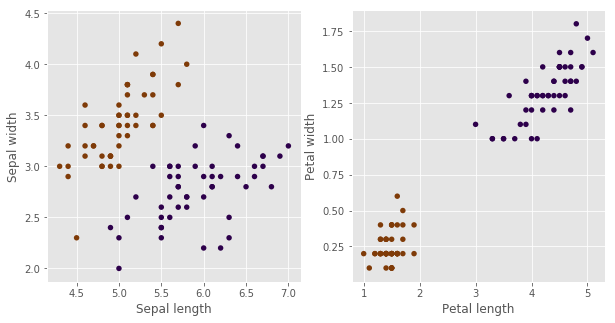

In [4]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [5]:
start = time.time()
pred_iris = Clustering().fit_predict(x_iris)
timer = time.time() - start
print ("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))
print(f"Time {timer}")

Adjusted Rand index for iris is: 1.00
Time 3.488978862762451


In [6]:
# Давайте проверим, как справляются sklearn реализации
sklearn_gmm = GaussianMixture(n_components=2)
gmm_t0 = time.time()
sklearn_gmm.fit(x_iris)
gmm_diff = time.time() - gmm_t0
gmm_score = smt.adjusted_rand_score(y_iris, sklearn_gmm.predict(x_iris))

sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("GMM score {}. GMM time {}. AGGL score {}. AGGL time {}".format(gmm_score, gmm_diff, aggl_score, aggl_diff))

GMM score 1.0. GMM time 0.2423703670501709. AGGL score 1.0. AGGL time 0.08110356330871582


Сверьте Ваш алгоритм с этими числами. Уверен, что у Вас получится не хуже!

# Боевое применение (2  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для анализа реальной задачи!

Важное замечание: в этой части задания студенту самому предлагается разобраться с данными и их форматом в качестве полезного упраженения. Не принимайте это близко к сердцу :)

Ввозьмем датасет различных стран.  
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   


Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам. 
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   

Необходимо показать, какие страны попали в общий кластер в и объяснить из-за каких признаков это произошло. Если страны были в одном кластере, а спустя несколько лет разъехались по разным кластерам, попробуйте это объяснить. 

In [7]:
# Место для Вашего кластерного анализа

df = pd.read_csv('WDIData.csv')

In [8]:
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Arab World,ARB,"2005 PPP conversion factor, GDP (LCU per inter...",PA.NUS.PPP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"2005 PPP conversion factor, private consumptio...",PA.NUS.PRVT.PP.05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,81.844982,82.407647,82.827636,83.169227,83.587141,83.954293,84.230630,84.570425,NaN,NaN
3,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,85.189815,86.136134,86.782683,87.288244,88.389705,88.076774,88.517967,88.768654,NaN,NaN
4,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,73.530494,74.543489,75.770972,76.772916,78.839139,77.487377,78.564439,78.958780,NaN,NaN


Данные очень большие, а у меня 2 или 4 ГБ памяти, так что я повыкидываю все, что захочу

Но подряд тоже выкидывать не хорошо, так что давайте найдем самый информативный год и оставим только его, т.к больше всего уходит столбцов на года, мне не хватит памяти...

In [9]:
Count_of_None = dict()
for i in range(1960, 2018):
    Count_of_None[i] = np.sum(df.loc[:, str(i)] == df.loc[:, str(i)])

In [10]:
max(Count_of_None, key=Count_of_None.get)

2010

In [11]:
df = df.loc[:, ['Country Name', 'Indicator Name', '2010']]

In [12]:
df.head()

,Country Name,Indicator Name,2010
0,Arab World,"2005 PPP conversion factor, GDP (LCU per inter...",NaN
1,Arab World,"2005 PPP conversion factor, private consumptio...",NaN
2,Arab World,Access to clean fuels and technologies for coo...,82.407647
3,Arab World,Access to electricity (% of population),86.136134
4,Arab World,"Access to electricity, rural (% of rural popul...",74.543489


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 422400 entries, 0 to 422399
Data columns (total 3 columns):
Country Name      422400 non-null object
Indicator Name    422400 non-null object
2010              236952 non-null float64
dtypes: float64(1), object(2)
memory usage: 9.7+ MB


ТУТ ПОДХОДИТ ТОЛЬКО ОДИН МЕМ

# МЕМ В ЛС СКИНУ

In [14]:
buf = df.dropna()

In [15]:
buf.head()

,Country Name,Indicator Name,2010
2,Arab World,Access to clean fuels and technologies for coo...,82.407647
3,Arab World,Access to electricity (% of population),86.136134
4,Arab World,"Access to electricity, rural (% of rural popul...",74.543489
5,Arab World,"Access to electricity, urban (% of urban popul...",95.837901
19,Arab World,"Adjusted net enrollment rate, primary (% of pr...",85.967873


In [16]:
df2 = buf.pivot(index='Country Name', columns='Indicator Name', values='2010')

In [17]:
df2.head()

Indicator Name,ARI treatment (% of children under 5 taken to a health provider),Access to clean fuels and technologies for cooking (% of population),Access to electricity (% of population),"Access to electricity, rural (% of rural population)","Access to electricity, urban (% of urban population)",Adequacy of social insurance programs (% of total welfare of beneficiary households),Adequacy of social protection and labor programs (% of total welfare of beneficiary households),Adequacy of social safety net programs (% of total welfare of beneficiary households),Adequacy of unemployment benefits and ALMP (% of total welfare of beneficiary households),"Adjusted net enrollment rate, primary (% of primary school age children)",...,"Women participating in the three decisions (own health care, major household purchases, and visiting family) (% of women age 15-49)",Women who believe a husband is justified in beating his wife (any of five reasons) (%),Women who believe a husband is justified in beating his wife when she argues with him (%),Women who believe a husband is justified in beating his wife when she burns the food (%),Women who believe a husband is justified in beating his wife when she goes out without telling him (%),Women who believe a husband is justified in beating his wife when she neglects the children (%),Women who believe a husband is justified in beating his wife when she refuses sex with him (%),Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24),Women's share of population ages 15+ living with HIV (%)
Country Name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,20.68,42.700000,32.400000,82.800000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,NaN,65.23,100.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,86.273308,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.3
Algeria,NaN,92.41,98.884972,97.594271,99.505684,NaN,NaN,NaN,NaN,98.887482,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.8
American Samoa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,NaN,100.00,100.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видим много не очень интересных колонок, давайте мне память сэкономим, и выкенем, где очень много None

In [18]:
from tqdm import tqdm
columns = []
ind_names = np.unique(df['Indicator Name'])
len_countries = len(np.unique(df['Country Name']))
for name in tqdm(ind_names):
    diff = df[df['Indicator Name'] == name]
    if np.sum(diff['2010'] == diff['2010']) >= 0.9 * len_countries:
        columns.append(name)

100%|██████████| 1600/1600 [03:49<00:00,  7.05it/s]


In [20]:
len(columns)

190

Все равно не хватит памяти (проверено)

Давайте еще уменьшим

In [21]:
columns2 = []
ind_names = columns
len_countries = len(np.unique(df['Country Name']))
for name in tqdm(ind_names):
    diff = df[df['Indicator Name'] == name]
    if np.sum(diff['2010'] == diff['2010']) >= 0.95 * len_countries:
        columns2.append(name)

100%|██████████| 190/190 [00:27<00:00,  6.71it/s]


In [22]:
len(columns2)

39

Попробуем...

In [24]:
buf2 = df.pivot(index='Country Name', columns='Indicator Name', values='2010')

In [27]:
buf2 = buf2.loc[:, columns2]

Теперь заменим все None нулями))

In [35]:
buf2.fillna(0, inplace=True)

In [46]:
cls = Clustering(k=12, linkage='complete')
y = cls.fit_predict(buf2)

In [54]:
buf2.iloc[y==1].index

Index(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Antigua and Barbuda', 'Arab World', 'Argentina', 'Armenia',
       ...
       'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela, RB', 'Vietnam',
       'Virgin Islands (U.S.)', 'West Bank and Gaza', 'Yemen, Rep.', 'Zambia',
       'Zimbabwe'],
      dtype='object', name='Country Name', length=229)

Похоже мы слишком сильно урезали данные, и страны стали слишком похожими...

Но увы, память не резиновая

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

***Ваше ответ здесь***

Мне легче описать на каких задачах я уже использовал

1 задача:
На хакатоне моя задача, как Дата сайнтиста в команде, была для пользователей анонимного чата подбирать похожих на основе их "Следа" (например, ответы на какие-то вопросы)
Чтобы увеличить скорость поиска, сначала данные кластеризовались, и при приходе нового пользователя сначала определялся его кластер, а потом находились похожие на него пользователи

2 задача:
Я писал свой Регрессор, данные были такие, что в них явно есть кластеры

Причем, если взять обычный, то результат получился хуже, чем если сначала кластезировать, и в каждом кластере построить свой Регрессор

Результат получился лучше, а потом я еще сделал на подобие random forest ансамбль из таких регрессоров, и получилось еще ненамного лучше

К сожалению, как оказалось на практике, мой алгоритм работал на специфичных данных хорошо, а на большинство стандартных не очень))

Как видно, я бы использовал их в качестве помощника для задач обучения с учителем.

# ----------------------------------

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

***Ваше ответ здесь***

K-means быстрый, прост как пробка, много хороших модификаций (k-means++ например),
но увы, все его кластеры имеют сферическую форму

Dbscan(у) не надо определять кол-во класстеров, кластеры любой формы, некоторые метрики качества могут плохо его оценивать (силуэт например, может получится отрицательным, в отличае от k-means). Но и он не идеальный, работает только при статичной плотности кластеров.

Агломеративная кластеризация - наглядный и понятный, кластера могут быть любой формы...
Из минусов - любит кушать процессорное время.

# ------------------------

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

***Ваше ответ здесь***

Не очень поинмаю смысл вопроса, поэтому отвечу верно, но тупо - когда не выполняется ограниченность $ \{p(X | Θ^i)\}_i $

# ---------------------------

* Многие алгоритмы анализа данных страдают "проклятием" размерности. Страдают ли этим проклятием алгоритмы кластеризации? Если да, то как бы Вы с этим боролись?

***Ваше ответ здесь***

Страдают сильнее, чем другие алгоритмы, которые мы изучили.

Алгоритмы кластеризации используют такое понятие, как расстояние, хоть метрика и выбирается по-разному, но из-за огромной размерности расстояние теряет смысл, т.к все объекты становятся друг на друга не похожи.

# ---------------------------

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

***Ваше ответ здесь***

Ну либо посидеть самому разметить какую-то часть, а потом запустить какой-нибудь наивный баес

Либо самому сделать какие-то слова к каждой тематике, а потом one-hot кодирование, и кластеризация

Лучше 1 вариант

# ---------------------

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

***Ваше ответ здесь***

Хм, я уже частично ответил на вопрос, но все же можно дополнить, что для k-means можно использовать размеченные данные как выбор центров класстеров, а как мы знаем, выбор центров - это единственное, что можно улучшать в k-means.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

# Я ЛИШЬ ХОЧУ СКИНУТЬ МЕМ ПРО ЭТУ РАБОТУ